In [1]:
import pandas as pd
import numpy as np
#import tushare as ts
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import pymysql
conn = pymysql.connect(host='localhost',port=3306,db='fund',user='root',passwd='root',charset='utf8')
def sele(sql):
    cur = conn.cursor()
    cur.execute(sql)
    result = list(cur.fetchall())
    result = [list(r) for r in result]
    conn.commit()
    cur.close()
    
    return result


In [3]:
#sql = 'select id, fundCode, FSRQ, DWJZ, LJJZ, JZZZL from jzhistory where fundCode = "260108"'
sql = 'select * from jzhistory where fundCode = "260108"'
data = sele(sql)

In [4]:
jzframe = pd.DataFrame(data, 
                        columns=['id', 'code', 'date', 'unitJZ', 'totalJZ','SDATE', 'ACTUALSYI', 'NAVTYPE', 'rate',\
                                'buyStatus', 'saleStatus', 'FHFCZ', 'FHFCBZ', 'DTYPE', 'FHSP'])

# drop saleStatus=封闭期 
jzframe = jzframe[jzframe['saleStatus'] != '封闭期']

# drop week day in 6, 7
from datetime import datetime
jzframe['weekday'] = jzframe['date'].apply(lambda x: datetime.weekday(datetime.strptime(x,'%Y-%m-%d'))+1)
jzframe = jzframe.drop(index=jzframe[jzframe['weekday'].isin([6,7])].index)

jzframe = jzframe[['code', 'date', 'unitJZ', 'totalJZ', 'rate',\
                              'buyStatus', 'saleStatus', 'FHFCZ']]

# FHFCZ
jzframe.loc[jzframe['FHFCZ']=='', 'FHFCZ'] = '0'
# rate
jzframe.loc[jzframe['rate']=='', 'rate'] = '0'

# cover str to float
jzframe[['unitJZ', 'totalJZ', 'rate', 'FHFCZ']] = jzframe[['unitJZ', 'totalJZ', 'rate', 'FHFCZ']].astype('float')

# cover str to date
jzframe[['date']] = jzframe[['date']].astype('datetime64')

# FHFCZ
jzframe = jzframe.rename(columns={'FHFCZ':'red'})

# sort
jzframe = jzframe.sort_values(by=['date'])
jzframe = jzframe.reset_index()
jzframe = jzframe.drop(['index'], axis=1)
print(jzframe)



        code       date  unitJZ  totalJZ  rate buyStatus saleStatus  red
0     260108 2006-08-29   1.001    1.001  0.20      开放申购       开放赎回  0.0
1     260108 2006-08-30   1.001    1.001  0.00      开放申购       开放赎回  0.0
2     260108 2006-08-31   1.001    1.001  0.00      开放申购       开放赎回  0.0
3     260108 2006-09-01   0.998    0.998 -0.30      开放申购       开放赎回  0.0
4     260108 2006-09-04   1.001    1.001  0.30      开放申购       开放赎回  0.0
...      ...        ...     ...      ...   ...       ...        ...  ...
3423  260108 2020-09-17   2.579    4.216 -1.79      开放申购       开放赎回  0.0
3424  260108 2020-09-18   2.606    4.243  1.05      开放申购       开放赎回  0.0
3425  260108 2020-09-21   2.571    4.208 -1.34      开放申购       开放赎回  0.0
3426  260108 2020-09-22   2.568    4.205 -0.12      开放申购       开放赎回  0.0
3427  260108 2020-09-23   2.594    4.231  1.01      开放申购       开放赎回  0.0

[3428 rows x 8 columns]


In [13]:
groups = jzframe['buyStatus'].groupby(jzframe['buyStatus'])
#print(jzframe)
groups.count()



buyStatus
开放申购      3411
暂停申购        10
限制大额申购       7
Name: buyStatus, dtype: int64

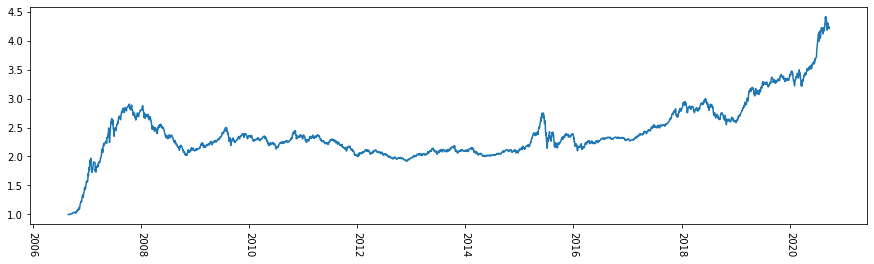

rate2_round
-32.0      1
-30.0      1
-27.0      2
-26.0      1
-25.0      1
-24.0      1
-23.0      1
-22.0      1
-19.0      1
-18.0      4
-17.0      1
-16.0      2
-15.0      3
-14.0      6
-13.0      8
-12.0      9
-11.0     12
-10.0     28
-9.0      26
-8.0      42
-7.0      55
-6.0      67
-5.0     110
-4.0     166
-3.0     169
-2.0     263
-1.0     269
 0.0     368
 1.0     383
 2.0     345
 3.0     298
 4.0     244
 5.0     180
 6.0     122
 7.0      74
 8.0      59
 9.0      29
 10.0     32
 11.0     16
 12.0     12
 13.0      5
 14.0      5
 15.0      3
 16.0      1
 21.0      1
 25.0      1
Name: rate2_round, dtype: int64


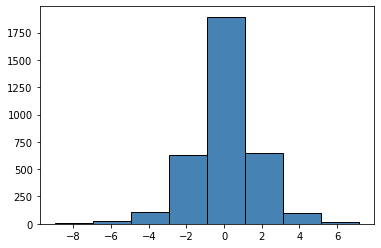

In [43]:
fig = plt.figure(figsize=(15,4))
plt.plot(jzframe['date'], jzframe['totalJZ'])
# 旋转标签
plt.xticks(rotation=-90)
plt.show()

jzframe['rate2'] = jzframe['rate'].round()
for index, row in jzframe.iterrows():
    if index <= 6:
        continue
    rate2 = jzframe.loc[index-1,'rate'] + jzframe.loc[index-2,'rate'] + jzframe.loc[index-3,'rate'] + jzframe.loc[index-4,'rate'] + jzframe.loc[index-5,'rate'] + jzframe.loc[index-6,'rate'] + jzframe.loc[index-7,'rate']
    jzframe.loc[index,'rate2'] = rate2

jzframe['rate2_round'] = jzframe['rate2'].round()
groups = jzframe['rate2_round'].groupby(jzframe['rate2_round'])
df = groups.count()
print(df)
plt.hist(jzframe['rate'],bins = 8,color = 'steelblue',edgecolor = 'black')
plt.show()

In [8]:
buy_amount = 100
buy_rate = 0.0015
def _sale_rate(day):
    if day < 7:
        sale_rate = 0.015
    elif day < 365:
        sale_rate = 0.005
    elif day < 365*2:
        sale_rate = 0.0025
    else
        sale_rate = 0.0
    return sale_rate


day0
num = (buy_amount * (1 - buy_rate))/unitJZ
day1
day = d1-d0
sale_amount = num*unitJZ(1-_sale_rate(day))
final_rate = (sale_amount-buy_amount)/buy_amount

SyntaxError: invalid syntax (<ipython-input-8-59bb8e48a284>, line 10)

In [9]:
# 
jzframe['isUp'] = False
jzframe['isLow'] = False
jzframe.loc[jzframe[jzframe['rate']>0].index,'isUp'] = True
jzframe


,code,date,unitJZ,totalJZ,rate,buyStatus,saleStatus,red,last_day_isUp,isLow,isUp
0,260108,2006-08-29,1.001,1.001,0.20,开放申购,开放赎回,0.0,False,False,True
1,260108,2006-08-30,1.001,1.001,0.00,开放申购,开放赎回,0.0,False,False,False
2,260108,2006-08-31,1.001,1.001,0.00,开放申购,开放赎回,0.0,False,False,False
3,260108,2006-09-01,0.998,0.998,-0.30,开放申购,开放赎回,0.0,False,False,False
4,260108,2006-09-04,1.001,1.001,0.30,开放申购,开放赎回,0.0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
3423,260108,2020-09-17,2.579,4.216,-1.79,开放申购,开放赎回,0.0,False,False,False
3424,260108,2020-09-18,2.606,4.243,1.05,开放申购,开放赎回,0.0,False,False,True
3425,260108,2020-09-21,2.571,4.208,-1.34,开放申购,开放赎回,0.0,False,False,False
3426,260108,2020-09-22,2.568,4.205,-0.12,开放申购,开放赎回,0.0,False,False,False


In [10]:
jzframe['last_day_isUp'] = False
for index, row in jzframe.iterrows():
    if index == 0:
        continue
    last_day_isUp = jzframe.loc[index-1,'isUp']
    jzframe.loc[index,'last_day_isUp'] = last_day_isUp

def f1(x):
    if x > 0:
        return True
    else:
        return False
jzframe['last_2_days_isUp'] = False
for index, row in jzframe.iterrows():
    if index <= 1:
        continue
    last_2_days_isUp = jzframe.loc[index-2,'rate'] + jzframe.loc[index-1,'rate']
    jzframe.loc[index,'last_2_days_isUp'] = f1(last_2_days_isUp)

jzframe['last_3_days_isUp'] = False
for index, row in jzframe.iterrows():
    if index <= 2:
        continue
    last_3_days_isUp = jzframe.loc[index-3,'rate'] + jzframe.loc[index-2,'rate'] + jzframe.loc[index-1,'rate']
    jzframe.loc[index,'last_3_days_isUp'] = f1(last_3_days_isUp)

jzframe['last_4_days_isUp'] = False
for index, row in jzframe.iterrows():
    if index <= 3:
        continue
    last_4_days_isUp = jzframe.loc[index-4,'rate'] + jzframe.loc[index-3,'rate'] + jzframe.loc[index-2,'rate'] + jzframe.loc[index-1,'rate']
    jzframe.loc[index,'last_4_days_isUp'] = f1(last_4_days_isUp)

jzframe['last_5_days_isUp'] = False
for index, row in jzframe.iterrows():
    if index <= 4:
        continue
    last_5_days_isUp = jzframe.loc[index-5,'rate'] + jzframe.loc[index-4,'rate'] + jzframe.loc[index-3,'rate'] + jzframe.loc[index-2,'rate'] + jzframe.loc[index-1,'rate']
    jzframe.loc[index,'last_5_days_isUp'] = f1(last_5_days_isUp)

jzframe['last_6_days_isUp'] = False
for index, row in jzframe.iterrows():
    if index <= 5:
        continue
    last_6_days_isUp = jzframe.loc[index-6,'rate'] + jzframe.loc[index-5,'rate'] + jzframe.loc[index-4,'rate'] + jzframe.loc[index-3,'rate'] + jzframe.loc[index-2,'rate'] + jzframe.loc[index-1,'rate']
    jzframe.loc[index,'last_6_days_isUp'] = f1(last_6_days_isUp)


    
jzframe

,code,date,unitJZ,totalJZ,rate,buyStatus,saleStatus,red,last_day_isUp,isLow,isUp,last_2_days_isUp,last_3_days_isUp,last_4_days_isUp,last_5_days_isUp,last_6_days_isUp
0,260108,2006-08-29,1.001,1.001,0.20,开放申购,开放赎回,0.0,False,False,True,False,False,False,False,False
1,260108,2006-08-30,1.001,1.001,0.00,开放申购,开放赎回,0.0,True,False,False,False,False,False,False,False
2,260108,2006-08-31,1.001,1.001,0.00,开放申购,开放赎回,0.0,False,False,False,True,False,False,False,False
3,260108,2006-09-01,0.998,0.998,-0.30,开放申购,开放赎回,0.0,False,False,False,False,True,False,False,False
4,260108,2006-09-04,1.001,1.001,0.30,开放申购,开放赎回,0.0,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3423,260108,2020-09-17,2.579,4.216,-1.79,开放申购,开放赎回,0.0,False,False,False,False,True,True,True,True
3424,260108,2020-09-18,2.606,4.243,1.05,开放申购,开放赎回,0.0,False,False,True,False,False,False,False,True
3425,260108,2020-09-21,2.571,4.208,-1.34,开放申购,开放赎回,0.0,True,False,False,False,False,False,False,True
3426,260108,2020-09-22,2.568,4.205,-0.12,开放申购,开放赎回,0.0,False,False,False,False,False,False,False,False


In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
tree = DecisionTreeClassifier(random_state=14)

X_pre = jzframe[['last_day_isUp','last_2_days_isUp','last_3_days_isUp']].values
y_true = jzframe[['isUp']].values
scores = cross_val_score(tree, X_pre, y_true, scoring='accuracy')

print('score: {:.2f}%'.format(np.mean(scores)*100))


score: 53.59%
